# CSE 6040: Attack-Oriented and Defense-Oriented Pokemon
________________________________________________________________________________________________________________


## Purpose

- Find the most effective attack-oriented and defense-oriented teams for each generation of Pokemon based on type match-ups and stats

- Make assumptions that enable a younger audience (or first time Pokemon players) to have an easier time choosing an effective team

_____

## Question

- What ratio of stat total to typing effectiveness yields the best attack-oriented and defense-oriented teams for each generation of Pokemon?

_____

## Datasets


**Pokedex: Comprehensive list of all pokemon through Generation 8 (cleaned to include only the fields below)**

- Pokedex Number: Think of this like a Pokemon's ID number (unique identifier)
- Name: Pokemon's name (Japanese and German names are also available, but I will use English here)
- Generation: Which generation each Pokemon was introduced in (1-8)
- Status: How each Pokemon is classified (Normal, Legendary, etc.)
- Type 1: Primary type of each Pokemon (Fire, Water, etc.)
- Type 2: Secondary type of each Pokemon (will be NaN if a Pokemon doesn't have a Secondary type)
- Total Points: Sum of all stats (Attack, Special Attack, Defense, Special Defense, Speed, HP)
- Attack: One of the stats used to determine our Attack-Oriented Team
- Special Attack: One of the stats used to determine our Attack-Oriented Team
- Speed: One of the stats used to determine our Attack-Oriented Team (and used to break ties when sorting)
- Defense: One of the stats used to determine our Defense-Oriented Team
- Special Defense: One of the stats used to determine our Defense-Oriented Team
- HP (Hit Points): One of the stats used to determine our Defense-Oriented Team (and used to break ties when sorting)


**Type Chart: Denotes which type are strong and weak against other types (matrix formatting)**

- If type matchup = 0.0 --> type shown in row has no effect when attacking type in column
- If type matchup = 0.5 --> type shown in row is only half as effective when attacking type in column
- If type matchup = 1.0 --> type shown in row is effective (baseline) when attacking type in column
- If type matchup = 2.0 --> type shown in row is super effective (twice as effective) when attacking type in column


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as wg

# Pokedex
# - Some Pokemon from earlier generations were introduced with new forms in later generations.
# - These later generation Pokemon were given the same Pokedex number / generation as the original
# - I changed these new forms (Alolan/Galarian) to have the generations they themselves were introduced in

pokedex = pd.read_csv('cse6040_pokedex.csv')
pokedex['generation'] = np.where(pokedex['name'].str.contains('Alolan'), 7, pokedex['generation'])
pokedex['generation'] = np.where(pokedex['name'].str.contains('Galarian'), 8, pokedex['generation'])
pokedex = pokedex[['pokedex_number', 'name', 'generation', 'status', 'type_1', 'type_2', 'total_points',
                   'attack', 'sp_attack', 'defense', 'sp_defense', 'speed', 'hp']]
display(pokedex.head(5))

# Typechart
# - Column name changed to 'type' since we will be using it in merges later

typechart = pd.read_csv('cse6040_typechart.csv')
typechart = typechart.rename(columns = {"Unnamed: 0": "type"})
display(typechart.head(5))

# Verify that we have no missing data in the Pokedex columns we will use
# Some Pokemon only have one type, so it is expected to have NaN values in type_2

display(pokedex.isnull().any())

,pokedex_number,name,generation,status,type_1,type_2,total_points,attack,sp_attack,defense,sp_defense,speed,hp
0,1,Bulbasaur,1,Normal,Grass,Poison,318,49,65,49,65,45,45
1,2,Ivysaur,1,Normal,Grass,Poison,405,62,80,63,80,60,60
2,3,Venusaur,1,Normal,Grass,Poison,525,82,100,83,100,80,80
3,3,Mega Venusaur,1,Normal,Grass,Poison,625,100,122,123,120,80,80
4,4,Charmander,1,Normal,Fire,NaN,309,52,60,43,50,65,39


,type,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,Normal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,0.5,1.0
1,Fire,1.0,0.5,0.5,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,0.5,1.0,2.0,1.0
2,Water,1.0,2.0,0.5,1.0,0.5,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0
3,Electric,1.0,1.0,2.0,0.5,0.5,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0
4,Grass,1.0,0.5,2.0,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,0.5,2.0,1.0,0.5,1.0,0.5,1.0


pokedex_number    False
name              False
generation        False
status            False
type_1            False
type_2             True
total_points      False
attack            False
sp_attack         False
defense           False
sp_defense        False
speed             False
hp                False
dtype: bool

_________

## ATTACK-ORIENTED

### Background

- Individual pokemon can be described as offensive (attack-oriented), defensive (defense), or well-rounded
- We will be focusing on attack-oriented Pokemon in this section
- To make things simpler, we will just be focusing on stats (attack, special attack, and speed) and typing (ex. Fire, Water, etc.) to define attack-oriented pokemon (there are other things that can influence this categorization, like ability and moveset, but we won't be looking at those)

### Methodology

#### Short Explanation

- Metrics for typing effectiveness and attack stats are created.
- Weights are applied to either metric (50/50, 70/30, etc.)
- We will be exploring which ratios (weights) between type and stats gives the best attack-oriented team

#### Long Explanation

- Since some Pokemon types are super effective (2x) against more types than others, and Pokemon have different stat totals, I wanted to explore how each Pokemon would rank when considering both typing and attack-oriented stat totals
- In order to quantify typing, I used the typechart to create a score by adding all the effectiveness points (0.0, 0.5, 1.0, 2.0) for a Pokemon's typing. The higher the score, the better. If a pokemon has two types, then the max of the two typings' effectiveness against every individual type was used.
- In order to quantify attack stat totals, the individual stats of attack, special attack, and speed were added together.
- For both typing and stats, Pokemon were ranked against one another. To get a final ranking that accounts for both typing and stats, a weight was applied to either (ex. typing x 0.3 and stats x 0.7, typing x 0.5 and stats x 0.5, etc.) depending on which aspect we value more, and the result of these were added together to get the final ranking.
- From these rankings, a team of 6 for each generation (1-8) was produced and scatterplots were developed to show the relationship between attack stat totals and type efficiency for each ratio (0/100, 10/90, ... , 100/0). The type efficiency score is derived from the type composition of the team of 6 (it gives a higher score according to both the type ranking from before and how many unique types are represented by the team of 6; higher is better) 
- We will be exploring which ratios (weights) between type and stats gives the best attack-oriented team
- "Special" Pokemon (Legendaries, Megas, etc.) were excluded since they are not obtained normally

_______

### Functions

- The functions below are used to condense the code and systematically apply conditions to dataframes
- You don't really need to look at these (unless you want to)

In [2]:

# Applies filter conditions to dataframes

def set_conditions(df, gen, status, mega):
    return df.loc[(df['generation'] == gen) & (df['status'].isin(status)) & (~df['name'].str.contains(mega))]


# Gets 6 Pokemon based on input dataframes ('type_df', 'stats_df')
# Uses an adjustment factor ('adj') to create a final score for each pokemon
# This final score determines which 6 Pokemin are chosen (highest scores)

def get_attack_teams(type_final_df, stats_final_df, adj, gen, status, mega):
    
    attack_type_df = set_conditions(type_final_df, gen, status, mega).reset_index(drop = True)
    attack_stats_df = set_conditions(stats_final_df, gen, status, mega).reset_index(drop = True)
    attack_type_df['attack_type_rank'] = attack_type_df.index
    attack_stats_df['attack_stats_rank'] = attack_stats_df.index
    attack_merge = pd.merge(attack_stats_df, attack_type_df, on = "name")
    attack_merge['attack_stats_adj'] = attack_merge['attack_stats_rank'] * (adj/100)
    attack_merge['attack_type_adj'] = attack_merge['attack_type_rank'] * (1 - adj/100)
    attack_merge['attack_rank'] = attack_merge['attack_stats_adj'] + attack_merge['attack_type_adj']
    attack_df = attack_merge.copy()[['name', 'attack_rank', 'attack_type_score']].sort_values(by = 'attack_rank').reset_index(drop = True)
    attack_team = attack_df['name'].head(6).tolist()
    attack_pokedex_merge = pd.merge(pokedex, attack_df, on = "name", how = "left")
    attack_pokedex = attack_pokedex_merge[['pokedex_number', 'name', 'type_1', 'type_2', 'attack', 'sp_attack', 
                                 'defense', 'sp_defense', 'speed', 'hp', 'attack_type_score']]
    attack_pokedex = attack_pokedex.rename(
        columns = {'pokedex_number': 'Pokedex Number', 'name': 'Name', 'type_1': 'Primary Type',
                   'type_2': 'Secondary Type', 'attack': 'Attack', 'sp_attack': 'Special Attack',
                   'defense': 'Defense', 'sp_defense': 'Special Defense', 'speed': 'Speed', 'hp': 'HP'})
    final_attack_team = attack_pokedex[attack_pokedex['Name'].isin(attack_team)]
    return final_attack_team


# Creates scatterplot values

def make_attack_plot_values(team_df, plot_df, i, x):
    
    stats_sum = team_df['Attack'].sum() + team_df['Special Attack'].sum() + team_df['Speed'].sum()
    type_sum = team_df['attack_type_score'].sum()
    team_df = team_df.drop(['attack_type_score'], axis = 1)
    temp_types = []
    temp_types.append(pd.unique(team_df['Primary Type']))
    temp_types.append(pd.unique(team_df['Secondary Type']))
    concat_types = np.concatenate((temp_types[0], temp_types[1]))
    types_unique = [*set(concat_types)]
    types_unique = [x for x in types_unique if str(x) != 'nan']
    type_efficiency_score = round(type_sum * len(types_unique) / 12, 2)
    plot_df.loc[len(plot_df.index)] = [str(i), int(stats_sum), type_efficiency_score, x] 
    
    
# Creates scatterplot graph
    
def make_attack_plot_visuals(plot_df, gen):
    
    new_df = plot_df[plot_df['Generation'] == str(gen)]
    values = new_df['Attack Stats Total']
    classes = new_df['Type Efficiency Score']
    ratios = new_df['Ratio']
    jittered_values = values + 20 * np.random.rand(len(values))
    jittered_classes = classes + 2 * np.random.rand(len(classes))
    plt.figure(figsize=(12,5))
    plt.xlabel('Attack Stats Total')
    plt.ylabel('Type Effeiciency Score')
    plt.title('Generation ' + str(i))
    scatter = plt.scatter(jittered_values, jittered_classes, s = 400, c = ratios, alpha = 0.8)
    legend1 = plt.legend(*scatter.legend_elements(), loc="upper left", title="Ratio")
    plt.show()
    


_____

### Type Ranking

- Ties in ranking will be broken using 'total points', then 'speed', then 'name'
- We will be removing "special" Pokemon (Legendary, etc.) before performing analysis since these are not normally obtained and have abnormally high stats
- A high score is better since this means the Pokemon's types can effectively attack more types


In [3]:

# Individually evaluating each of the Pokemon's two types

pokedex_2 = pokedex[['pokedex_number', 'name', 'generation', 'status', 'type_1', 'type_2', 'total_points', 'speed']]
pokedex_type1 = pokedex_2.drop(columns = ['type_2']).rename(columns = {"type_1": "type"})
pokedex_type2 = pokedex_2.drop(columns = ['type_1']).rename(columns = {"type_2": "type"})
type1 = pd.merge(pokedex_type1, typechart, on = 'type').drop(columns = ['type'])
type2 = pd.merge(pokedex_type2, typechart, on = 'type').drop(columns = ['type'])

# Merging the two types and creating the type score

pokedex_concat = pd.concat([type1, type2])
pokedex_group = pokedex_concat.groupby('name').max().reset_index()
pokedex_group['attack_type_score'] = pokedex_group.iloc[:,6:23].sum(axis=1)

# Creates the ranking

names = ['pokedex_number', 'name', 'generation', 'status', 'attack_type_score', 'total_points', 'speed']
attack_type = pokedex_group[names]
sort_by = ['attack_type_score', 'total_points', 'speed', 'name']
sort_ascending = [False, False, False, True]
attack_type = attack_type.sort_values(by = sort_by, ascending = [False, False, False, True]).reset_index(drop = True)

# Displays the 5 highest ranked for attack type score

attack_type_final = attack_type.copy()[['name', 'generation', 'status', 'attack_type_score']]
display(attack_type_final.head(5))


,name,generation,status,attack_type_score
0,Mamoswine,4,Normal,26.0
1,Crabominable,7,Normal,26.0
2,Piloswine,2,Normal,26.0
3,Swinub,2,Normal,26.0
4,Primal Groudon,3,Legendary,25.0


_____

### Stats Ranking

- Ties in ranking will be broken using 'total points', then 'speed', then 'name'
- We will be removing "special" Pokemon (Legendary, etc.) before performing analysis since these are not normally obtained and have abnormally high stats
- A high score is better since this means the Pokemon has higher attack stats

In [4]:

# Creates an attack stats score and ranking

pokedex_att_pre = pokedex[['pokedex_number', 'name', 'generation', 'status', 
                           'attack', 'sp_attack', 'total_points', 'speed']]
pokedex_att = pokedex_att_pre.copy()
pokedex_att["attack_stats_score"] = pokedex["attack"] + pokedex["sp_attack"] + pokedex["speed"]
sort_by = ['attack_stats_score', 'total_points', 'speed', 'name']
sort_ascending = [False, False, False, True]
attack_stats = pokedex_att.sort_values(by = sort_by, ascending = sort_ascending).reset_index(drop = True)

# Displays the 5 highest ranked for attack stats score

attack_stats_final = attack_stats.copy()[['name', 'generation', 'status', 'attack_stats_score']]
display(attack_stats_final.head(5))


,name,generation,status,attack_stats_score
0,Deoxys Attack Forme,3,Mythical,510
1,Mega Mewtwo Y,1,Legendary,484
2,Mega Rayquaza,3,Legendary,475
3,Mega Mewtwo X,1,Legendary,474
4,Ultra Necrozma,7,Legendary,463


_____

### Type vs. Stats Plots

- Plots were created based on Type Efficiency Score vs. Attack Stats Total for each Generation (1-8)
- Ratios (weights) are shown in the colored legend
- A Ratio of 0 means we only use the metrics for a Pokemon's typing (no stats) and a ratio of 100 means we only use the metrics for attack stats (no typing) 


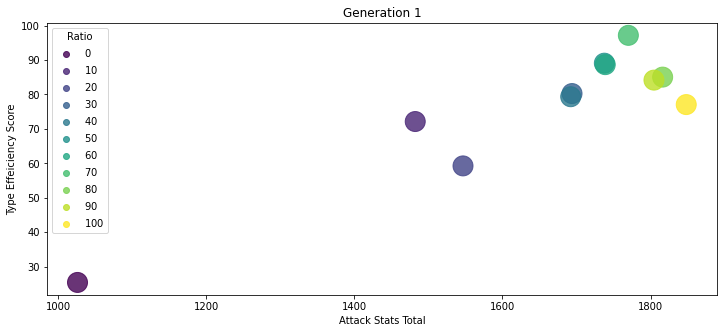

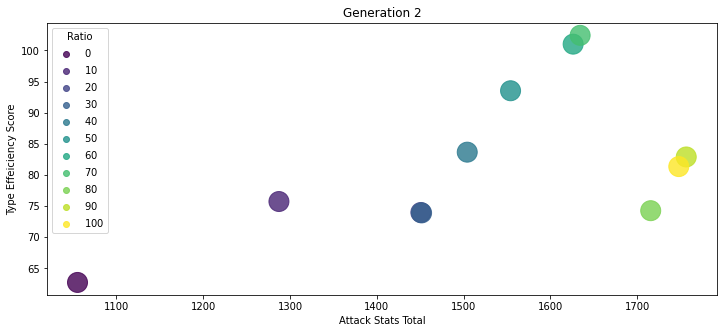

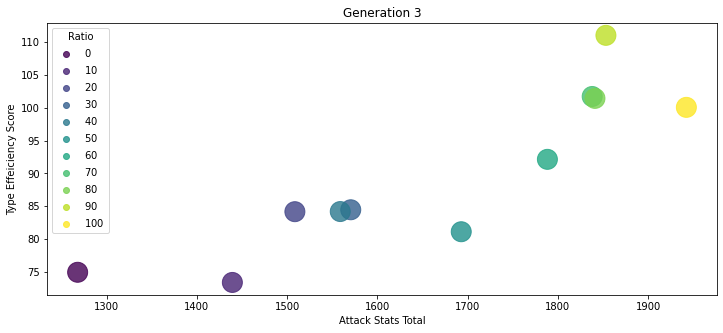

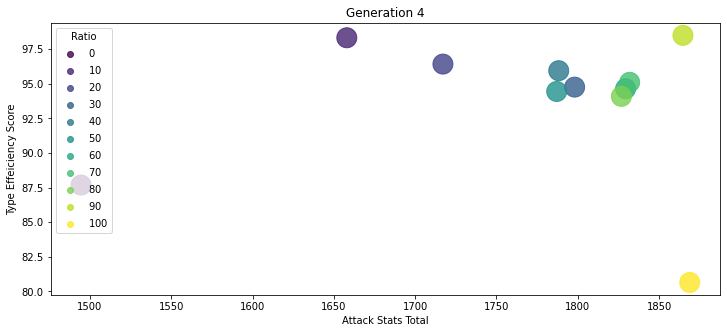

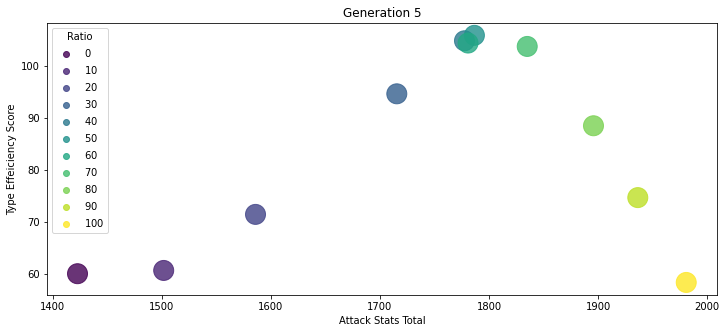

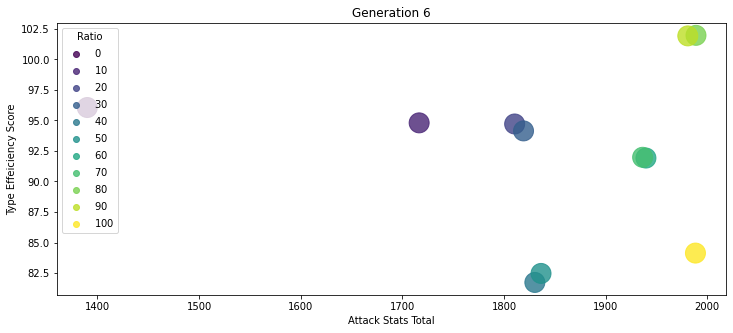

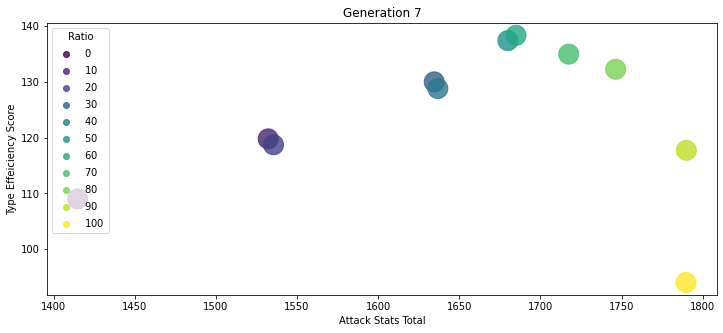

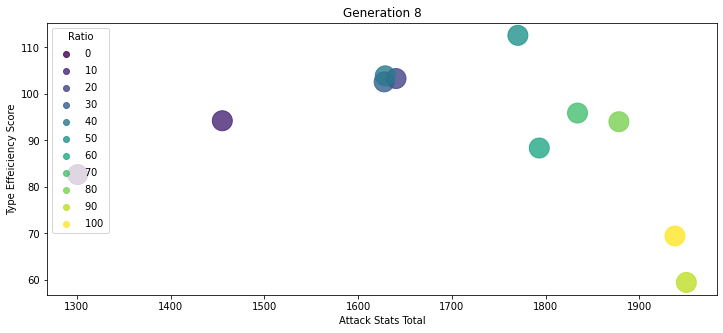

In [5]:

plot_df = pd.DataFrame({'Generation': pd.Series(dtype='str'), 'Attack Stats Total': pd.Series(dtype='int'),
                        'Type Efficiency Score': pd.Series(dtype='float'), 'Ratio': pd.Series(dtype='str')})

for x in range(0, 101, 10):
    for i in range(1,9):
        team_df = get_attack_teams(attack_type_final, attack_stats_final, x, i, ['Normal'], 'Mega')
        plot_df_values = make_attack_plot_values(team_df, plot_df, i, x)
        if x == 100: # change to 100 for output
            make_attack_plot_visuals(plot_df, i)
        

### Attack-Oriented Conclusion

#### Analysis (Data)

- Ratios between 60/40 and 80/20 (Stats/Typing) tend to give the best attack-oriented teams (at a glance)
- Obviously, a ratio of 100/0 gives the team with the highest total attack stats, but it is up to the individual to decide how they value pure stats and typing
- Other factors need to be considered when someone is choosing their team, but this range gives good options

#### Analysis (Personal Knowledge)

- Certain types (like Fighting and Ice) tend to have higher Attack Stat Totals
- Because of this, there is less unique typing amongst the Pokemon at the top of the rankings for Attack Stats
- Less unique typings results in a lower Type Efficiency Score, so if a pokemon does not have a Secondary Type, it naturally hurts the score as well
- This offers an explanation for why there is a significant dip in the 90/10 and 100/0 ratios for some generations 

#### Analysis (Interactive)

- In order to see the Pokemon that comprise the teams at each level of analysis, I created an "Interactive Section" at the bottom of the notebook. You can choose which ratio you want to investigate and if you want to disable repeated typings (essentially forcing the highest Type Efficiency Score) to get a 6 Pokemon team. The resulting 6 Pokemon based on the conditions you choose will be shown.

_________

## DEFENSE-ORIENTED

### Background

- Individual pokemon can be described as offensive (attack-oriented), defensive (defense), or well-rounded
- We will be focusing on defense-oriented Pokemon in this section
- To make things simpler, we will just be focusing on stats (defense, special defense, and HP) and typing (ex. Fire, Water, etc.) to define defense-oriented pokemon (there are other things that can influence this categorization, like ability and moveset, but we won't be looking at those)

### Methodology

#### Short Explanation

- Metrics for typing resistance and defense stats are created.
- Weights are applied to either metric (50/50, 70/30, etc.)
- We will be exploring which ratios (weights) between type and stats gives the best defense-oriented team

#### Long Explanation

- Since some Pokemon types are resistant (0x or 0.5x) to more types than others, and Pokemon have different stat totals, I wanted to explore how each Pokemon would rank when considering both typing and defense-oriented stat totals
- In order to quantify typing, I used the typechart to create a score by adding all the effectiveness points (0.0, 0.5, 1.0, 2.0) of types trying to attack our Pokemon's typing. The lower the score, the better. If a pokemon has two types, then the effectiveness score against each type will be multiplied together (this is how the games calculate it as well).
- In order to quantify defense stat totals, the individual stats of defense, special defense, and hp were added together.
- For both typing and stats, Pokemon were ranked against one another. To get a final ranking that accounts for both typing and stats, a weight was applied to either (ex. typing x 0.3 and stats x 0.7, typing x 0.5 and stats x 0.5, etc.) depending on which aspect we value more, and the result of these were added together to get the final ranking.
- From these rankings, a team of 6 for each generation (1-8) was produced and scatterplots were developed to show the relationship between defense stat totals and type efficiency for each ratio (0/100, 10/90, ... , 100/0). The type efficiency score is derived from the type composition of the team of 6 (it gives a higher score according to both the type ranking from before and how many unique types make up the team of 6; higher is better) 
- We will be exploring which ratios (weights) between type and stats gives the best defense-oriented team
- "Special" Pokemon (Legendaries, Megas, etc.) were excluded since they are not obtained normally

_______

### Functions

- The functions below are used to condense the code and systematically apply conditions to dataframes
- You don't really need to look at these (unless you want to)

In [6]:
# Gets 6 Pokemon based on input dataframes ('type_df', 'stats_df')
# Uses an adjustment factor ('adj') to create a final score for each pokemon
# This final score determines which 6 Pokemin are chosen (highest scores)

def get_defense_teams(type_final_df, stats_final_df, adj, gen, status, mega):
    
    defense_type_df = set_conditions(type_final_df, gen, status, mega).reset_index(drop = True)
    defense_stats_df = set_conditions(stats_final_df, gen, status, mega).reset_index(drop = True)
    defense_type_df['defense_type_rank'] = defense_type_df.index
    defense_stats_df['defense_stats_rank'] = defense_stats_df.index
    defense_merge = pd.merge(defense_stats_df, defense_type_df, on = "name")
    defense_merge['defense_stats_adj'] = defense_merge['defense_stats_rank'] * (adj/100)
    defense_merge['defense_type_adj'] = defense_merge['defense_type_rank'] * (1 - adj/100)
    defense_merge['defense_rank'] = defense_merge['defense_stats_adj'] + defense_merge['defense_type_adj']
    defense_df = defense_merge.copy()[['name', 'defense_rank', 'defense_type_score']].sort_values(by = 'defense_rank').reset_index(drop = True)
    defense_team = defense_df['name'].head(6).tolist()
    defense_pokedex_merge = pd.merge(pokedex, defense_df, on = "name", how = "left")
    defense_pokedex = defense_pokedex_merge[['pokedex_number', 'name', 'type_1', 'type_2', 'attack', 'sp_attack', 
                                 'defense', 'sp_defense', 'speed', 'hp', 'defense_type_score']]
    defense_pokedex = defense_pokedex.rename(
        columns = {'pokedex_number': 'Pokedex Number', 'name': 'Name', 'type_1': 'Primary Type',
                   'type_2': 'Secondary Type', 'attack': 'Attack', 'sp_attack': 'Special Attack',
                   'defense': 'Defense', 'sp_defense': 'Special Defense', 'speed': 'Speed', 'hp': 'HP'})
    final_defense_team = defense_pokedex[defense_pokedex['Name'].isin(defense_team)]
    return final_defense_team


# Creates scatterplot values

def make_defense_plot_values(team_df, plot_df, i, x):
    
    stats_sum = team_df['Defense'].sum() + team_df['Special Defense'].sum() + team_df['HP'].sum()
    type_sum = team_df['defense_type_score'].sum()
    team_df = team_df.drop(['defense_type_score'], axis = 1)
    temp_types = []
    temp_types.append(pd.unique(team_df['Primary Type']))
    temp_types.append(pd.unique(team_df['Secondary Type']))
    concat_types = np.concatenate((temp_types[0], temp_types[1]))
    types_unique = [*set(concat_types)]
    types_unique = [x for x in types_unique if str(x) != 'nan']
    type_efficiency_score = round(type_sum * len(types_unique) / 12, 2)
    plot_df.loc[len(plot_df.index)] = [str(i), int(stats_sum), type_efficiency_score, x] 
    
    
# Creates scatterplot graph
    
def make_defense_plot_visuals(plot_df, gen):
    
    new_df = plot_df[plot_df['Generation'] == str(gen)]
    values = new_df['Defense Stats Total']
    classes = new_df['Type Efficiency Score']
    ratios = new_df['Ratio']
    jittered_values = values + 20 * np.random.rand(len(values))
    jittered_classes = classes + 2 * np.random.rand(len(classes))
    plt.figure(figsize=(12,5))
    plt.xlabel('Defense Stats Total')
    plt.ylabel('Type Effeiciency Score')
    plt.title('Generation ' + str(i))
    scatter = plt.scatter(jittered_values, jittered_classes, s = 400, c = ratios, alpha = 0.8)
    legend1 = plt.legend(*scatter.legend_elements(), loc="upper left", title="Ratio")
    plt.show()
    

_____

### Type Ranking

- Ties in ranking will be broken using 'total points', then 'hp', then 'name'
- We will be removing "special" Pokemon (Legendary, etc.) before performing analysis since these are not normally obtained and have abnormally high stats
- A low score is better since this means more types won't be effective when attacking it

In [7]:

# Creates a defense type score

pd.options.mode.chained_assignment = None # Suppress warnings (you can ignore this)

pokedex_2 = pokedex[['pokedex_number', 'name', 'generation', 'status', 'type_1', 'type_2', 'total_points', 'hp']]
defense_typechart = typechart.copy()
defense_pokedex = pokedex_2.copy()
defense_pokedex['defense_type_score'] = float()
defense_pokedex['type_2'] = defense_pokedex['type_2'].fillna("missing")

# Differentiates between single-type and dual-type Pokemon
# Single-types can just take the sum of the type column
# Dual-types have to multiply the two type columns together, then sum

for i in range(len(defense_pokedex)):
    if defense_pokedex['type_2'][i] == "missing":
        temp = defense_typechart[[defense_pokedex['type_1'][i]]]
        defense_sum = temp[defense_pokedex['type_1'][i]].sum()
        defense_pokedex['defense_type_score'][i] = defense_sum
    else:
        temp = defense_typechart[[defense_pokedex['type_1'][i], defense_pokedex['type_2'][i]]]
        temp2 = temp[defense_pokedex['type_1'][i]] * temp[defense_pokedex['type_2'][i]]
        defense_sum = temp2.sum()
        defense_pokedex['defense_type_score'][i] = defense_sum

pd.options.mode.chained_assignment = 'warn' # Unsuppress warnings (you can ignore this)

# Creates a defense type ranking

names = ['pokedex_number', 'name', 'generation', 'status', 'defense_type_score', 'total_points', 'hp']
defense_type = defense_pokedex[names]
sort_by = ['defense_type_score', 'total_points', 'hp', 'name']
sort_ascending = [True, False, False, True]
defense_type = defense_type.sort_values(by = sort_by, ascending = sort_ascending).reset_index(drop = True)

# Displays the 5 highest ranked for defense type score

defense_type_final = defense_type.copy()[['name', 'generation', 'status', 'defense_type_score']]
display(defense_type_final.head(5))


,name,generation,status,defense_type_score
0,Zacian Crowned Sword,8,Legendary,13.25
1,Magearna,7,Mythical,13.25
2,Mega Mawile,3,Normal,13.25
3,Klefki,6,Normal,13.25
4,Mawile,3,Normal,13.25


_____

### Stats Ranking

- Ties in ranking will be broken using 'total points', then 'speed', then 'name'
- We will be removing "special" Pokemon (Legendary, etc.) before performing analysis since these are not obtained normally and have abnormally high stats
- A high score is better since this means the Pokemon has higher defense stats

In [8]:

# Creates defense stats ranking

pokedex_def_pre = pokedex[['pokedex_number', 'name', 'generation', 'status', 
                           'defense', 'sp_defense', 'total_points', 'hp']]
pokedex_def = pokedex_def_pre.copy()
pokedex_def["defense_stats_score"] = pokedex["defense"] + pokedex["sp_defense"] + pokedex["hp"]
sort_by = ['defense_stats_score', 'total_points', 'hp', 'name']
sort_ascending = [False, False, False, True]
defense_stats = pokedex_def.sort_values(by = sort_by, ascending = sort_ascending).reset_index(drop = True)

# Displays the 5 highest ranked for defense stats score

defense_stats_final = defense_stats.copy()[['name', 'generation', 'status', 'defense_stats_score']]
display(defense_stats_final.head(5))


,name,generation,status,defense_stats_score
0,Eternatus Eternamax,8,Legendary,755
1,Shuckle,2,Normal,480
2,Zygarde Complete Forme,6,Legendary,432
3,Mega Steelix,2,Normal,400
4,Blissey,2,Normal,400


_____

### Type vs. Stats Plots

- Plots were created based on Type Efficiency Score vs. Defense Stats Total for each Generation (1-8)
- Ratios (weights) are shown in the colored legend
- A Ratio of 0 means we only use the metrics for a Pokemon's typing (no stats) and a ratio of 100 means we only use the metrics for defense stats (no typing) 


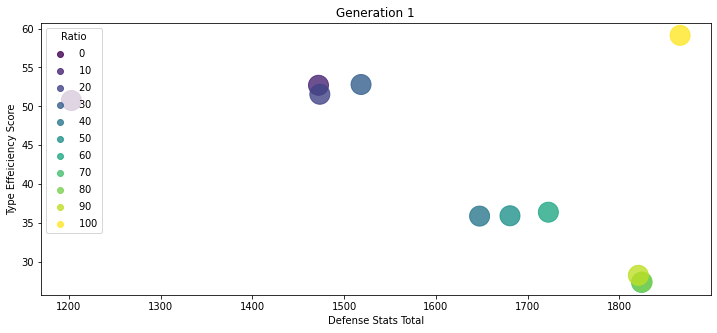

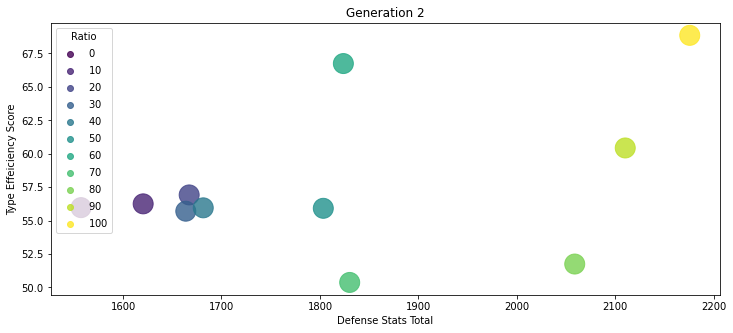

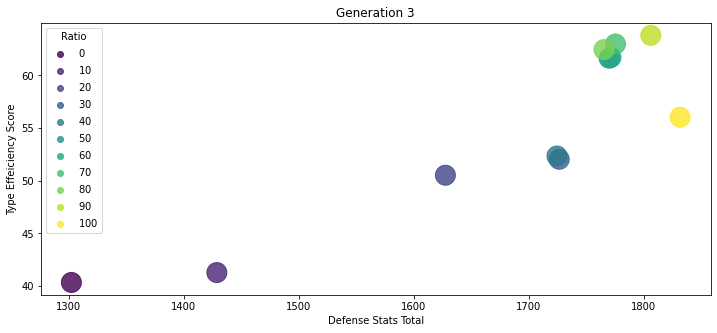

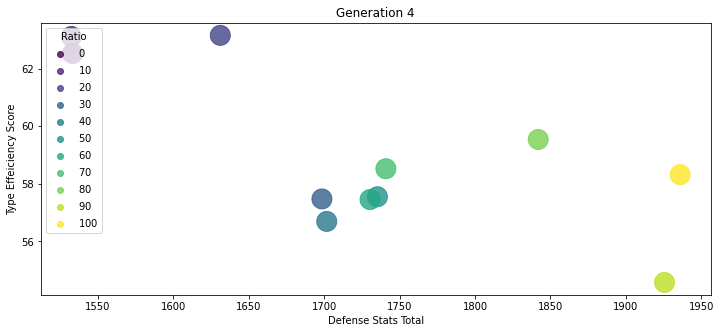

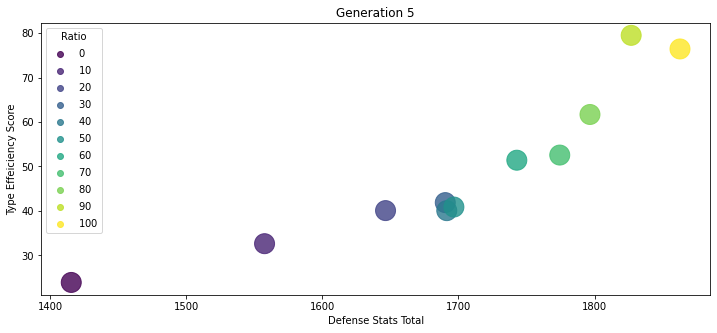

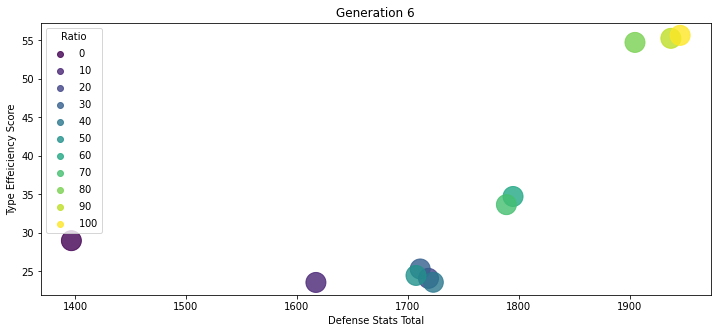

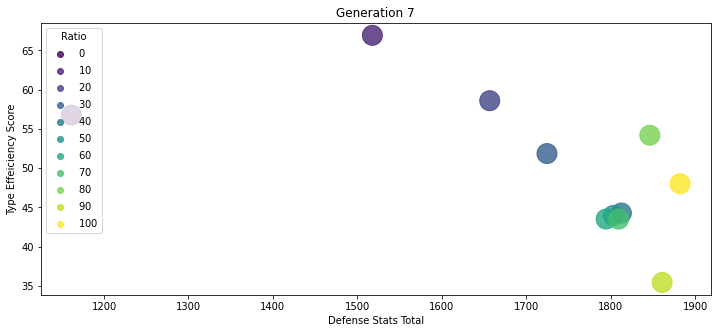

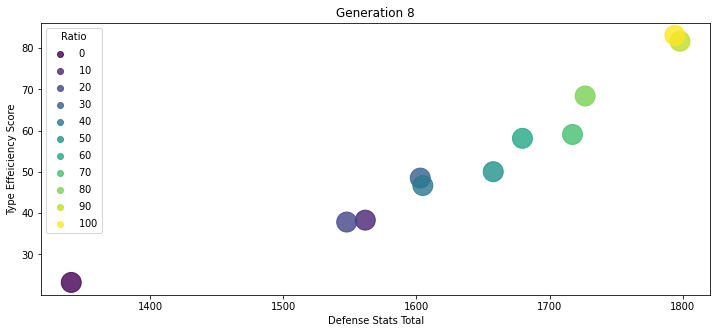

In [9]:

plot_df = pd.DataFrame({'Generation': pd.Series(dtype='str'), 'Defense Stats Total': pd.Series(dtype='int'),
                        'Type Efficiency Score': pd.Series(dtype='float'), 'Ratio': pd.Series(dtype='str')})

for x in range(0, 101, 10):
    for i in range(1,9):
        team_df = get_defense_teams(defense_type_final, defense_stats_final, x, i, ['Normal'], 'Mega')
        plot_df_values = make_defense_plot_values(team_df, plot_df, i, x)
        if x == 100: # change to 100 for output
            make_defense_plot_visuals(plot_df, i)
        

### Defense-Oriented Conclusion

#### Analysis (Data)

- Ratios between 80/20 and 100/0 (Stats/Typing) tend to give the best defense-oriented teams (at a glance)
- However, there seemed to be less of a pattern than we saw with the Attack-Oriented analysis
- Obviously, a ratio of 100/0 gives the team with the highest total defense stats, but it is up to the individual to decide how they value pure stats and typing
- Other factors need to be considered when someone is choosing their team, but this range gives good options

#### Analysis (Personal Knowledge)

- Certain type combinations have very few weaknesses (1 or 2), so if these select combinations all show up in the same generation, it is going to skew our data pretty heavily. This is to say, there is much more variability in having a good typing defensively than there is typing offensively since almost all dual-type Pokemon will be able to super effectively hit multiple other types, but may be resistant to almost everything when defending.
- Certain types are also more defense-oriented naturally (ex. Steel), so if a lot of Steel types are in the same generation, out Type Efficiency will be low
- Less unique typings results in a lower Type Efficiency Score, so if a pokemon does not have a Secondary Type, it naturally hurts the score as well
- This offers an explanation for why there is a significant dip in the 90/10 and 100/0 ratios for some generations 

#### Analysis (Interactive)

- In order to see the Pokemon that comprise the teams at each level of analysis, I created an "Interactive Section" at the bottom of the notebook. You can choose which ratio you want to investigate and if you want to disable repeated typings (essentially forcing the highest Type Efficiency Score) to get a 6 Pokemon team. The resulting 6 Pokemon based on the conditions you choose will be shown.

_____

## Overall Conclusion

- There is no "perfect" attack-oriented or defense-oriented team, but some teams are better than others due to their stats and typing
- The scatterplots in the previous sections help show that base stats are generally more important than typing, but both are important to building effective teams. These visualizations also show that a "good" team in one generation may be less suitable in another generation due to changing type combinations (see the variability of the final defense-oriented teams).

### Future Research

- In the future, it would be advantageous to look at some of the factors we ommitted (namely ability) to give additional metrics for determining attack and defense teams (for example, some abilities raise a Pokemon's own attack stats)
- It would also be interesting to take an optimization approach to building teams of 6 with no types overlapping between them. In the "Interactive Section" below, I introduce a way to eliminate duplicate types between Pokemon on a team, but it just goes by the rankings (top down) and adds to the team as it goes, rather than finding the optimal group of Pokemon that gives the best composite ranking.


_____
_____

## INTERACTIVE SECTION

### Purpose

- This is a fun add-on to build your own attack-oriented and defense-oriented teams
- You will be able to choose the ratio between stat totals and typing efficiency using the slider
- You will be able to ensure your team does not contain any duplicate types using the "repeated types" button
- You will be able to choose the generation of Pokemon your team comes from using the dropdown menu


### Functions

- The functions below are used to condense the code and systematically apply conditions to dataframes
- Functionality for the interactive elements (slider, checkbox, etc.) are housed here
- You don't really need to look at these (unless you want to)

In [10]:

### SLIDER FUNNCTIONS ###

def get_slider_input():
    
    def on_value_change(change):
        with slider_output:
            print(change['new'])
     
    slider = wg.IntSlider(value=50, min=0, max=100)
    slider_output = wg.Output()
    print('\n' + ' <---- Type vs. Stats ---->')
    display(slider)
    slider.observe(on_value_change, names='value')
    
    return slider_output

def put_slider_output(slideroutput):
    
    try :
        slider_number = int(vars(slideroutput)['_trait_values']['outputs'][0]['text'].strip().split('\n')[-1])
        opp_slider_number = 100 - slider_number
    except IndexError:
        slideroutput = 50
        slider_number = slideroutput
        opp_slider_number = 100 - slider_number
        
    return slider_number, opp_slider_number


### CHECKBOX FUNCTIONS ###

def get_checkbox_input():
    
    def on_value_change(change):
        with check_output:
            print(change['new'])
    
    check = wg.ToggleButton(value=False, description='Repeated Types: Off', disabled=False)
    check_output = wg.Output()
    display(check)
    check.observe(on_value_change, names='value')
    
    return check_output

def put_checkbox_output(check_input):
    
    try :
        check_boolean = vars(check_input)['_trait_values']['outputs'][0]['text'].strip().split('\n')[-1]
        if check_boolean == 'True':
            check_boolean = True
        elif check_boolean == 'False':
            check_boolean = False
    except IndexError:
        check_boolean = False
        
    return check_boolean
    

### DROPDOWN FUNCTIONS ###
    
def get_dropdown_input():
    
    def on_value_change(change):
        with drop_output:
            print(change['new'])
    
    drop = wg.Dropdown(options=['1', '2', '3', '4', '5', '6', '7', '8'], value = '1', 
                       description='Generation', disabled=False)
    drop_output = wg.Output()
    display(drop)
    drop.observe(on_value_change, names='value')
    
    return drop_output

def put_dropdown_output(drop_input):
    
    try :
        drop_number = int(vars(drop_input)['_trait_values']['outputs'][0]['text'].strip().split('\n')[-1])
    except IndexError:
        drop_number = 1

    return drop_number


### UNIQUE TYPING FUNCTION ###

def no_repeated_types(names):

    types_used = []
    number_of_pokemon = 6
    final_team = []
    
    for name in names:
        pokemon = pokedex[pokedex['name'] == name]
        if number_of_pokemon == 0: break
        if (pokemon['type_1'].tolist()[0] not in types_used) and (pokemon['type_2'].tolist()[0] not in types_used):
            types_used.append(pokemon['type_1'].tolist()[0])
            types_used.append(pokemon['type_2'].tolist()[0])
            final_team.append(pokemon['name'].tolist()[0])
            number_of_pokemon -= 1
            if types_used.count('NaN') > 0: types_used.remove('NaN')
            
    return final_team


### FINAL ATTACK TEAM FUNCTION ###

def get_unique_attack_teams(type_final_df, stats_final_df, adj, gen, status, mega):
    
    attack_type_df = set_conditions(type_final_df, gen, status, mega).reset_index(drop = True)
    attack_stats_df = set_conditions(stats_final_df, gen, status, mega).reset_index(drop = True)
    attack_type_df['attack_type_rank'] = attack_type_df.index
    attack_stats_df['attack_stats_rank'] = attack_stats_df.index
    attack_merge = pd.merge(attack_stats_df, attack_type_df, on = "name")
    attack_merge['attack_stats_adj'] = attack_merge['attack_stats_rank'] * (adj/100)
    attack_merge['attack_type_adj'] = attack_merge['attack_type_rank'] * (1 - (adj/100))
    attack_merge['attack_rank'] = attack_merge['attack_stats_adj'] + attack_merge['attack_type_adj']
    attack_df = attack_merge.copy()[['name', 'attack_rank']].sort_values(by = 'attack_rank').reset_index(drop = True) 
    attack_team = attack_df['name'].tolist()
    attack_team = no_repeated_types(attack_team)
    attack_pokedex = pokedex[['pokedex_number', 'name', 'type_1', 'type_2', 'attack', 'sp_attack', 
                                 'defense', 'sp_defense', 'speed', 'hp']]
    attack_pokedex = attack_pokedex.rename(
        columns = {'pokedex_number': 'Pokedex Number', 'name': 'Name', 'type_1': 'Primary Type',
                   'type_2': 'Secondary Type', 'attack': 'Attack', 'sp_attack': 'Special Attack',
                   'defense': 'Defense', 'sp_defense': 'Special Defense', 'speed': 'Speed', 'hp': 'HP'})
    final_attack_team = attack_pokedex[attack_pokedex['Name'].isin(attack_team)]
    final_attack_team = final_attack_team.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    final_attack_team = final_attack_team.set_properties(**{'text-align': 'center'}).hide_index()
    
    return final_attack_team


### FINAL DEFENSE TEAM FUNCTION ###

def get_unique_defense_teams(type_final_df, stats_final_df, adj, gen, status, mega):
    
    defense_type_df = set_conditions(type_final_df, gen, status, mega).reset_index(drop = True)
    defense_stats_df = set_conditions(stats_final_df, gen, status, mega).reset_index(drop = True)
    defense_type_df['defense_type_rank'] = defense_type_df.index
    defense_stats_df['defense_stats_rank'] = defense_stats_df.index
    defense_merge = pd.merge(defense_stats_df, defense_type_df, on = "name")
    defense_merge['defense_stats_adj'] = defense_merge['defense_stats_rank'] * (adj/100)
    defense_merge['defense_type_adj'] = defense_merge['defense_type_rank'] * (1 - (adj/100))
    defense_merge['defense_rank'] = defense_merge['defense_stats_adj'] + defense_merge['defense_type_adj']
    defense_df = defense_merge.copy()[['name', 'defense_rank']].sort_values(by = 'defense_rank').reset_index(drop = True) 
    defense_team = defense_df['name'].tolist()
    defense_team = no_repeated_types(defense_team)
    defense_pokedex = pokedex[['pokedex_number', 'name', 'type_1', 'type_2', 'attack', 'sp_attack', 
                                 'defense', 'sp_defense', 'speed', 'hp']]
    defense_pokedex = defense_pokedex.rename(
        columns = {'pokedex_number': 'Pokedex Number', 'name': 'Name', 'type_1': 'Primary Type',
                   'type_2': 'Secondary Type', 'attack': 'Attack', 'sp_attack': 'Special Attack',
                   'defense': 'Defense', 'sp_defense': 'Special Defense', 'speed': 'Speed', 'hp': 'HP'})
    final_defense_team = defense_pokedex[defense_pokedex['Name'].isin(defense_team)]
    final_defense_team = final_defense_team.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    final_defense_team = final_defense_team.set_properties(**{'text-align': 'center'}).hide_index()
    
    return final_defense_team
    

## Set Your Conditions

- Run the below code chunk to display the slider, button, and drop down for the conditions
- You should only need to run this chunk once (even if you update your conditions, it should automatically update the values that will be used in the following code chunks)
- Feel free to just play around, there's not really any analysis to be down here

In [11]:
print('\nCHOOSE HOW MUCH TYPE AND STATS SHOULD BE WEIGHTED\n- The number on the right shows the weight (%) given to Stats')
slider_input = get_slider_input()

print('\nCHOOSE WHETHER YOU WANT TO ALLOW REPEATED TYPES\n- If you want to have a team of all differently typed Pokemon, click the button')
checkbox_input = get_checkbox_input()

print('\nCHOOSE WHICH GENERATION YOU WANT TO BUILD YOUR TEAM FROM\n- Defaults to Generation 1 if you dont choose for yourself')
dropdown_input = get_dropdown_input()


CHOOSE HOW MUCH TYPE AND STATS SHOULD BE WEIGHTED
- The number on the right shows the weight (%) given to Stats

 <---- Type vs. Stats ---->


IntSlider(value=50)


CHOOSE WHETHER YOU WANT TO ALLOW REPEATED TYPES
- If you want to have a team of all differently typed Pokemon, click the button


ToggleButton(value=False, description='Repeated Types: Off')


CHOOSE WHICH GENERATION YOU WANT TO BUILD YOUR TEAM FROM
- Defaults to Generation 1 if you dont choose for yourself


Dropdown(description='Generation', options=('1', '2', '3', '4', '5', '6', '7', '8'), value='1')

____

## Display Attack-Oriented and Defense-Oriented Teams

- Run the below code chunk to display the attack and defense teams resulting from the conditions you selected
- You should be able to change the conditions above without re-running the previous code chunk, you will just need to rerun the below chunk for the updated teams to display

In [12]:

slider_output = put_slider_output(slider_input)
checkbox_output = put_checkbox_output(checkbox_input)
dropdown_output = put_dropdown_output(dropdown_input)

if checkbox_output:
    print('\nAttack Team')
    display(get_unique_attack_teams(attack_type_final, attack_stats_final, slider_output[0], dropdown_output, ['Normal'], 'Mega'))
    print('\nDefense Team')
    display(get_unique_defense_teams(defense_type_final, defense_stats_final, slider_output[0], dropdown_output, ['Normal'], 'Mega'))
else:
    print('\nAttack Team')
    display(get_attack_teams(attack_type_final, attack_stats_final, slider_output[0], dropdown_output, ['Normal'], 'Mega').drop(columns='attack_type_score'))  
    print('\nDefense Team')
    display(get_defense_teams(defense_type_final, defense_stats_final, slider_output[0], dropdown_output, ['Normal'], 'Mega').drop(columns='defense_type_score'))  



Attack Team


,Pokedex Number,Name,Primary Type,Secondary Type,Attack,Special Attack,Defense,Special Defense,Speed,HP
6,6,Charizard,Fire,Flying,84,109,78,85,100,78
45,34,Nidoking,Poison,Ground,102,85,77,75,85,81
156,121,Starmie,Water,Psychic,75,100,85,85,115,60
167,130,Gyarados,Water,Flying,125,60,79,100,81,95
181,142,Aerodactyl,Rock,Flying,105,60,65,75,130,80
192,149,Dragonite,Dragon,Flying,134,100,95,100,80,91



Defense Team


,Pokedex Number,Name,Primary Type,Secondary Type,Attack,Special Attack,Defense,Special Defense,Speed,HP
47,36,Clefable,Fairy,NaN,70,95,73,90,60,95
92,73,Tentacruel,Water,Poison,70,80,65,120,100,80
118,89,Muk,Poison,NaN,105,65,75,100,50,105
143,110,Weezing,Poison,NaN,90,85,120,70,60,65
173,134,Vaporeon,Water,NaN,65,110,60,95,65,130
183,143,Snorlax,Normal,NaN,110,65,65,110,30,160
